# Small business loan, machine learning models

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import folium
import os
import json
import numpy as np
import requests
from scipy.stats import linregress
from sklearn.metrics import accuracy_score, roc_curve, auc, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

Reads in the data and saves it the a pickle file. Use it only the very first time. Link to data https://www.sba.gov/about-sba/sba-performance/open-government/foia/frequently-requested-records/sba-7a-504-loan-data-reports.

In [3]:
files = ['FOIA - 7(a)(FY1991-FY1999).xlsx', 'FOIA - 7(a)(FY2000-FY2009).xlsx', 'FOIA - 7(a)(FY2010-Present).xlsx']
sbloan_data = pd.concat([pd.read_excel(f) for f in files], ignore_index=True)
sbloan_data.to_pickle('SBL_dataset_7a.pkl')

Reads in the data from the pickle file.

In [110]:
sbloan_data = pd.read_pickle('SBL_dataset.pkl')
print(sbloan_data.shape)
sbloan_data.dtypes

(1490392, 34)


Program                          object
BorrName                         object
BorrStreet                       object
BorrCity                         object
BorrState                        object
BorrZip                           int64
BankName                         object
BankStreet                       object
BankCity                         object
BankState                        object
BankZip                          object
GrossApproval                     int64
SBAGuaranteedApproval             int64
ApprovalDate             datetime64[ns]
ApprovalFiscalYear                int64
FirstDisbursementDate    datetime64[ns]
DeliveryMethod                   object
subpgmdesc                       object
InitialInterestRate             float64
TermInMonths                      int64
NaicsCode                       float64
NaicsDescription                 object
FranchiseCode                    object
FranchiseName                    object
ProjectCounty                    object


In [111]:
sbloan_data.head()

,Program,BorrName,BorrStreet,BorrCity,BorrState,BorrZip,BankName,BankStreet,BankCity,BankState,...,ProjectCounty,ProjectState,SBADistrictOffice,CongressionalDistrict,BusinessType,LoanStatus,ChargeOffDate,GrossChargeOffAmount,RevolverStatus,JobsSupported
0,7A,"COPYTRON, INC.",2588 VANCE DRIVE,MT AIRY,MD,21771,Manufacturers and Traders Trust Company,"One M & T Plaza, 15th Fl",BUFFALO,NY,...,CARROLL,MD,BALTIMORE DISTRICT OFFICE,8.0,CORPORATION,PIF,NaT,0,0,0
1,7A,BODY SHOP,"BOX 503, S. HWY 71",WILLMAR,MN,56201,U.S. Bank National Association,425 Walnut St,Cincinnati,OH,...,KANDIYOHI,MN,MINNESOTA DISTRICT OFFICE,7.0,INDIVIDUAL,PIF,NaT,0,0,0
2,7A,"ROBINS INSURANCE AGENCY, INC.",30 BURTON HILLS BLVD.,NASHVILLE,TN,37215,SunTrust Bank,25 Park Place NE,ATLANTA,GA,...,DAVIDSON,TN,TENNESSEE DISTRICT OFFICE,5.0,CORPORATION,PIF,NaT,0,0,0
3,7A,"M.C. INTERNATIONAL, INC",1100-B TUCKAHOE DRIVE,NASHVILLE,TN,37207,"First Tennessee Bank, National Association","165 Madison Ave, 1st Fl",MEMPHIS,TN,...,DAVIDSON,TN,TENNESSEE DISTRICT OFFICE,5.0,CORPORATION,PIF,NaT,0,0,0
4,7A,"GBR, INC. & GERALD H & BONITA",1103 SPRUCE,YANKTON,SD,57078,CorTrust Bank National Association,100 E Havens Ave,MITCHELL,SD,...,YANKTON,SD,SOUTH DAKOTA DISTRICT OFFICE,0.0,INDIVIDUAL,PIF,NaT,0,0,0


Reads in the higher level NAICS codes datafile.

In [112]:
naicsCodes = pd.read_csv('NaicsCode_highlevel.txt')
naicsCodes

,Code,IndustryTitle,NoBusinessEst
0,11,Agriculture Forestry Fishing and Hunting,348550
1,21,Mining,28732
2,22,Utilities,34615
3,23,Construction,1369268
4,31,Manufacturing,604541
5,32,Manufacturing,604541
6,33,Manufacturing,604541
7,42,Wholesale Trade,679448
8,44,Retail Trade,1665458
9,45,Retail Trade,1665458


Creates a dictionary and adds a column with the Industry title to the dataframe. 

In [113]:
naicsCode_highlevel = dict(zip(naicsCodes.Code, naicsCodes.IndustryTitle))
naicsCode_highlevel[0] = ''
naicsCode_highlevel[99] = 'Mystery Industry'
Industries = dict(zip(naicsCodes.IndustryTitle, naicsCodes.NoBusinessEst))
sbloan_data['Industry'] = sbloan_data['NaicsCode'].apply(lambda x: naicsCode_highlevel[int(x//10000)] if pd.notnull(x) else 0)

Calculates the risk factor for a loan based on where the company is located and which business sector does it belong to. It calculates the ratio for loans from these categories that were charged off versus all loan from that category. Adds 4 coulmns to the dataset that contain the risk factors. 

It also adds a tag column, which will have a value of 0 if the loan was charged off and 1 otherwise. 

In [114]:
risks_choff = {}
risks_cancelled = {}
# print(sbloan_data.shape)
sbloan_notnull = sbloan_data[sbloan_data.ProjectState.notnull() & (sbloan_data.Industry != 0)].copy()
# print(sbloan_notnull.shape)
for state in list(sbloan_notnull.ProjectState.unique()):
    loan_data = sbloan_data[sbloan_data.ProjectState==state]
    risks_choff[state] = loan_data[loan_data.LoanStatus == 'CHGOFF'].shape[0]/loan_data.shape[0]
    risks_cancelled[state] = loan_data[loan_data.LoanStatus == 'CANCLD'].shape[0]/loan_data.shape[0]
sbloan_notnull['RiskStateCancelled'] = sbloan_notnull.ProjectState.map(lambda x: risks_cancelled[x])
sbloan_notnull['RiskStateChargedOff'] = sbloan_notnull.ProjectState.map(lambda x: risks_choff[x])
risks_choff = {}
risks_cancelled = {}
for indust in list(sbloan_notnull.Industry.unique()):
    loan_data = sbloan_data[sbloan_data.Industry==indust]
    risks_choff[indust] = loan_data[loan_data.LoanStatus == 'CHGOFF'].shape[0]/loan_data.shape[0]
    risks_cancelled[indust] = loan_data[loan_data.LoanStatus == 'CANCLD'].shape[0]/loan_data.shape[0]
sbloan_notnull['RiskIndustCancelled'] = sbloan_notnull.Industry.map(lambda x: risks_cancelled[x])
sbloan_notnull['RiskIndustChargedOff'] = sbloan_notnull.Industry.map(lambda x: risks_choff[x])
sbloan_notnull['Tag'] = sbloan_notnull.LoanStatus.map(lambda x: 1 if (x in ['COMMIT','PIF','EXEMPT','CANCLD']) else 0)

Sets asside the training and validation datasets. It can choose from several loan categories and balances the number of positive and negative tags. 

In [115]:
def training_set_def(tags, size):
    total_size = 0
    for i, tag in enumerate(tags):
        slicing = sbloan_notnull[sbloan_notnull.LoanStatus == tag]
        if i==0:
            if size > len(slicing):
                dataset = slicing.sample(len(slicing))
                total_size += len(slicing)
            else:
                dataset = slicing.sample(size)
                total_size += size
        else:
            if size > len(slicing):
                dataset = dataset.append(slicing.sample(len(slicing)))
                total_size += len(slicing)
            else:
                dataset = dataset.append(slicing.sample(size))
                total_size += size
    chgoff = sbloan_notnull[sbloan_notnull.LoanStatus == 'CHGOFF'].sample(total_size)
    dataset = dataset.append(chgoff)
    X = dataset[['ApprovalFiscalYear', 'GrossApproval','RiskStateCancelled', 'RiskStateChargedOff','RiskIndustCancelled', 'RiskIndustChargedOff']].copy()
    y = dataset['Tag'].copy()
    return(X, y)

Runs several machine learning models with various training sets. 


Taking into account only fully paid loans
Nearest Neighbors 0.6134545454545455
Decision Tree 0.6525555555555556
Random Forest 0.6581919191919192
Neural Net 0.5086767676767677
AdaBoost 0.6561010101010101
Naive Bayes 0.5221818181818182
QDA 0.6006060606060606

Taking into account fully paid and ongoing loans
Nearest Neighbors 0.7196060606060606
Decision Tree 0.7426161616161616
Random Forest 0.7509595959595959
Neural Net 0.5638383838383838
AdaBoost 0.7459191919191919
Naive Bayes 0.5525050505050505
QDA 0.7183939393939394

Taking into account fully paid, ongoing loans and recently approved loans
Nearest Neighbors 0.7488554118635776
Decision Tree 0.7812801826323645
Random Forest 0.7803770555548587


/Users/mvarga/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net 0.5015365703749232
AdaBoost 0.7772913713733803
Naive Bayes 0.5498914993163829
QDA 0.754361978350037


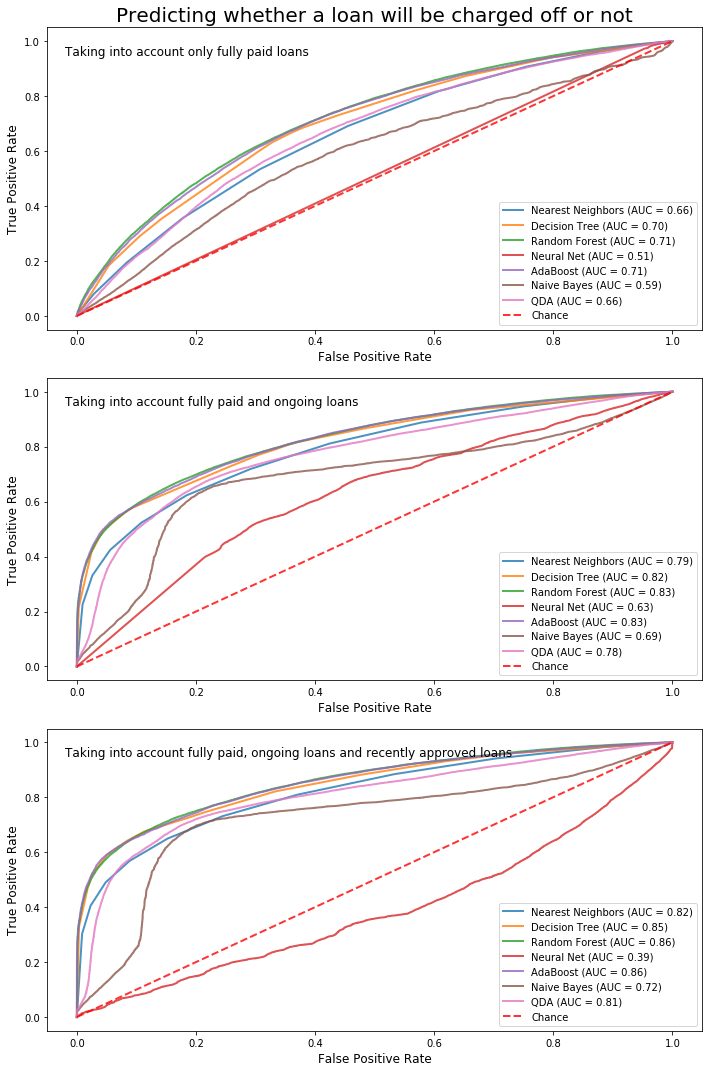

In [116]:
names = ["Nearest Neighbors",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(10),
    DecisionTreeClassifier(max_leaf_nodes=15),
    RandomForestClassifier(max_depth=15, n_estimators=20, max_features=5),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

plt.figure(figsize=(10,15))

plt.subplot(3,1,1)
plt.title('Predicting whether a loan will be charged off or not', fontsize = 20)

print('\nTaking into account only fully paid loans')
X, y = training_set_def(['PIF'], 150000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=374)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    predictions = clf.predict_proba(X_test)
    # score2 = accuracy_score(y_true = y_test, y_pred = predictions[:,1])
    print(name, score)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.8,
                 label='%s (AUC = %0.2f)' % (name, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.text(-0.02, 0.95, 'Taking into account only fully paid loans', fontsize = 12)

plt.subplot(3,1,2)
print('\nTaking into account fully paid and ongoing loans')
X, y = training_set_def(['PIF', 'EXEMPT'], 75000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=374)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    predictions = clf.predict_proba(X_test)
    # score2 = accuracy_score(y_true = y_test, y_pred = predictions[:,1])
    print(name, score)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.8,
                 label='%s (AUC = %0.2f)' % (name, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.text(-0.02, 0.95, 'Taking into account fully paid and ongoing loans', fontsize = 12)
    

plt.subplot(3,1,3)
print('\nTaking into account fully paid, ongoing loans and recently approved loans')
X, y = training_set_def(['PIF', 'EXEMPT', 'COMMIT'], 50000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=374)
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    predictions = clf.predict_proba(X_test)
    # score2 = accuracy_score(y_true = y_test, y_pred = predictions[:,1])
    print(name, score)
    fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, alpha=0.8,
                 label='%s (AUC = %0.2f)' % (name, roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.text(-0.02, 0.95, 'Taking into account fully paid, ongoing loans and recently approved loans', fontsize = 12)
    
    
plt.tight_layout()
plt.savefig('ROC_curve_7a.pdf')

Imports the census dataset and finds all zip codes from there that are in the dataset.

In [105]:
census2010 = pd.read_csv('2010+Census+Population+By+Zipcode+(ZCTA).csv')
census_zips = census2010['Zip Code ZCTA'].tolist()
zip_codes_in_census = [zcode for zcode in sbloan_data.BorrZip.unique() if zcode in census_zips]


A regression analysis for the number of loans for a given zipcode versus the population in the same area.

The coefficient of determination (R squared) for the fit using sklearn: 0.5463391631006999 and scpipy 0.5463391631007004.


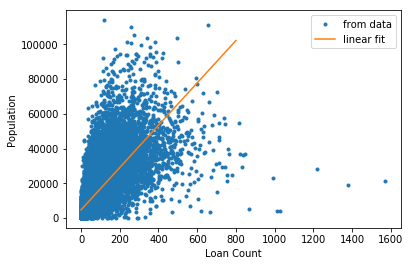

In [117]:
values = sbloan_data[sbloan_data.BorrZip.isin(zip_codes_in_census)][['BorrName', 'BorrZip']].groupby('BorrZip', as_index = False).count().rename({'BorrZip': 'ZIP_CODE', 'BorrName': 'Loan_Count'}, axis='columns')
census = census2010[census2010['Zip Code ZCTA'].isin(zip_codes_in_census)].rename({'Zip Code ZCTA': 'ZIP_CODE', '2010 Census Population': 'POPULATION'}, axis='columns')
values = values.merge(census, on='ZIP_CODE', how = 'inner')
fit = np.polyfit(values['Loan_Count'], values['POPULATION'], 1)
p = np.poly1d(fit)
xp = np.linspace(0, 800, 10)
plt.plot(values['Loan_Count'], values['POPULATION'], '.', label='from data')
plt.plot(xp, p(xp), '-', label='linear fit')
plt.legend()
plt.xlabel('Loan Count')
plt.ylabel('Population')
coefficient_of_dermination = r2_score(values['POPULATION'], p(values['Loan_Count']))
slope, intercept, r_value, p_value, std_err = linregress(values['Loan_Count'], values['POPULATION'])
print(f'The coefficient of determination (R squared) for the fit using sklearn: {coefficient_of_dermination} and scpipy {r_value**2}.')

Reads in the census dataset for the number of businesses in a given state using the websites API.

In [ ]:
key = '9c6c0a18fce7edfb274d05a81567c6e4b9a7e29d'
response = requests.get("https://api.census.gov/data/2014/ase/csa?get=FIRMPDEMP,EMP,GEO_TTL&for=state:*&key={}".format(key))


Cleans the dataset and creates a dictionary with the states as the keys and the number of businesses as the values.

In [93]:
raw_text = response.text.split('\n')
states = pd.read_csv('50_us_states_all_data.csv')
header = raw_text[0].strip(']').strip('[')
content = [a.strip('[').strip(']').split(',') for a in raw_text[1:]]
total_enterprises = {}
for line in raw_text[1:]:
    line = line.split(',')
    state = str(line[2]).strip('"')
    total_ent = int(line[0].strip('[').strip('"'))
    total_enterprises[state] = total_ent
states['no_enterprise'] = states.State.map(lambda x: total_enterprises[x])
    

A regression analysis for the number of loans per state and the number of businesses in the states.

The coefficient of determination (R squared) for the fit using sklearn: 0.9280040832734853 and scpipy 0.9280040832734848.


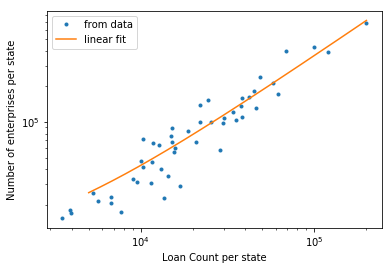

In [102]:
values = sbloan_data[['BorrName', 'BorrState']].groupby('BorrState', as_index = False).count().rename({'BorrState': 'Index', 'BorrName': 'Loan_Count'}, axis='columns')
values = values.merge(states[['State','Index','no_enterprise']], on='Index', how = 'inner')
fit = np.polyfit(values['Loan_Count'], values['no_enterprise'], 1)
p = np.poly1d(fit)
xp = np.linspace(5000, 200000, 10000)
plt.loglog(values['Loan_Count'], values['no_enterprise'], '.', label='from data')
plt.loglog(xp, p(xp), '-', label='linear fit')
plt.legend()
plt.xlabel('Loan Count per state')
plt.ylabel('Number of enterprises per state')
coefficient_of_dermination = r2_score(values['no_enterprise'], p(values['Loan_Count']))
slope, intercept, r_value, p_value, std_err = linregress(values['Loan_Count'], values['no_enterprise'])
print(f'The coefficient of determination (R squared) for the fit using sklearn: {coefficient_of_dermination} and scpipy {r_value**2}.')
plt.savefig('LoanCount_vs_NoBusinesses.pdf')